In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import os
import yaml
#from dotenv import load_dotenv

import Mandelbrot
from Mandelbrot import hurst #defined/customized functions from Mandelbrot.py

import scipy
from scipy.stats import norm, cauchy, lognorm, expon, kstest
from scipy.stats import linregress



In [2]:
MIN = Mandelbrot.process_csv(gran="min")
HOUR = Mandelbrot.process_csv(gran="hour")
DAY = Mandelbrot.process_csv(gran="day")
WEEK = Mandelbrot.process_csv(gran="week")
MONTH = Mandelbrot.process_csv(gran="month")

In [3]:
h_f = hurst()
h_f.fit(data=HOUR["high"], power=10, rolling_window="false")

Data gets divided into 11044 fixed windows of length 4
Data gets divided into 5522 fixed windows of length 8
Data gets divided into 2761 fixed windows of length 16
Data gets divided into 1380 fixed windows of length 32
Data gets divided into 690 fixed windows of length 64
Data gets divided into 345 fixed windows of length 128
Data gets divided into 172 fixed windows of length 256
Data gets divided into 86 fixed windows of length 512
Data gets divided into 43 fixed windows of length 1024


0.9881856137096712

In [6]:
HURST = []

for dataset in [HOUR,DAY]:
    HURST.append(h_f.fit(data=dataset["high"], power=10, rolling_window="false"))
    

Data gets divided into 11044 fixed windows of length 4
Data gets divided into 5522 fixed windows of length 8
Data gets divided into 2761 fixed windows of length 16
Data gets divided into 1380 fixed windows of length 32
Data gets divided into 690 fixed windows of length 64
Data gets divided into 345 fixed windows of length 128
Data gets divided into 172 fixed windows of length 256
Data gets divided into 86 fixed windows of length 512
Data gets divided into 43 fixed windows of length 1024
Data gets divided into 848 fixed windows of length 4
Data gets divided into 424 fixed windows of length 8
Data gets divided into 212 fixed windows of length 16
Data gets divided into 106 fixed windows of length 32
Data gets divided into 53 fixed windows of length 64
Data gets divided into 26 fixed windows of length 128
Data gets divided into 13 fixed windows of length 256
Data gets divided into 6 fixed windows of length 512
Data gets divided into 3 fixed windows of length 1024


In [7]:
print(HURST)

[0.9881856137096712, 0.9723525937186174]


In [20]:
###### ANALYZE FOR OVERFITTING!!!!!!

from statsmodels.tsa.stattools import adfuller
from scipy.signal import detrend

result = adfuller(DAY["high"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

#test for stationarity. If your series is nonstationary, the R/S analysis can give falsely high Hurst exponents
#p < 0.05 → likely stationary 
#p ≥ 0.05 → non-stationary (likely overfit Hurst)

ADF Statistic: -1.272777264382868
p-value: 0.6415329223148358


Data gets divided into 848 fixed windows of length 4
Data gets divided into 424 fixed windows of length 8
Data gets divided into 212 fixed windows of length 16
Data gets divided into 106 fixed windows of length 32
Data gets divided into 53 fixed windows of length 64
Data gets divided into 848 fixed windows of length 4
Data gets divided into 424 fixed windows of length 8
Data gets divided into 212 fixed windows of length 16
Data gets divided into 106 fixed windows of length 32
Data gets divided into 53 fixed windows of length 64


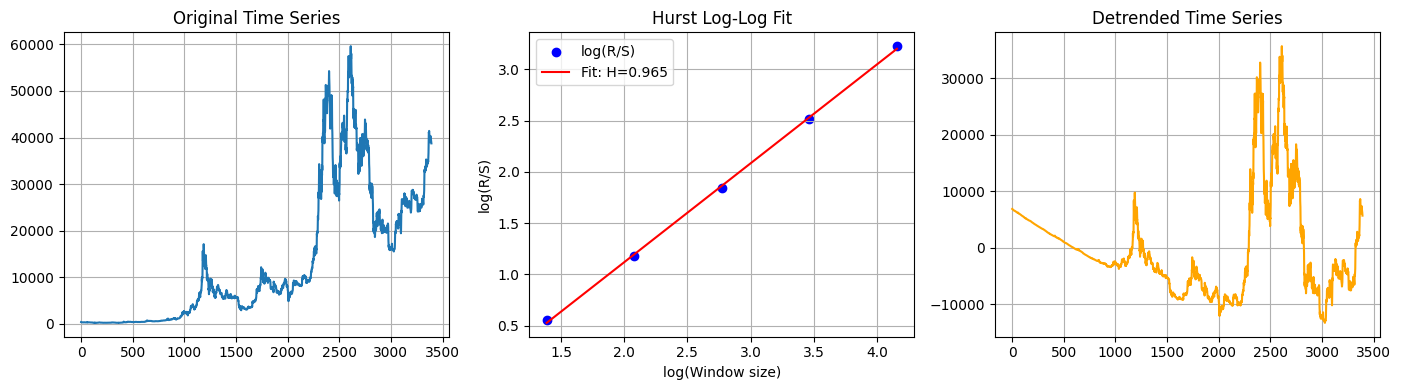

{'Original Hurst': 0.964882172836033,
 'Detrended Hurst': 0.978516430621951,
 'ADF Statistic': -1.272777264382868,
 'ADF p-value': 0.6415329223148358,
 'ADF Critical Values': {'1%': -3.4322948129049493,
  '5%': -2.8623993051360332,
  '10%': -2.5672274248944094}}

In [23]:
run_hurst_diagnostics(DAY["high"], max_power=6)

In [22]:
def run_hurst_diagnostics(data, max_power=6):
    h = hurst()
    hurst_val = h.fit(data, power=max_power)

    # ADF Test
    adf_stat, p_value, _, _, critical_values, _ = adfuller(data)

    # Detrend and re-calculate Hurst
    detrended_data = detrend(data)
    h_detrended = hurst()
    hurst_detrended = h_detrended.fit(detrended_data, power=max_power)

    # Plot original time series
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 3, 1)
    plt.plot(data, label="Original Time Series")
    plt.title("Original Time Series")
    plt.grid(True)

    # Plot log(R/S) vs log(L)
    plt.subplot(1, 3, 2)
    plt.scatter(np.log(h.subset_length), np.log(h.rs_range), label='log(R/S)', color='blue')
    plt.plot(np.log(h.subset_length), h.Y, label=f'Fit: H={h.hurst:.3f}', color='red')
    plt.xlabel('log(Window size)')
    plt.ylabel('log(R/S)')
    plt.title("Hurst Log-Log Fit")
    plt.legend()
    plt.grid(True)

    # Plot detrended time series
    plt.subplot(1, 3, 3)
    plt.plot(detrended_data, label="Detrended Series", color='orange')
    plt.title("Detrended Time Series")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return {
        "Original Hurst": h.hurst,
        "Detrended Hurst": hurst_detrended,
        "ADF Statistic": adf_stat,
        "ADF p-value": p_value,
        "ADF Critical Values": critical_values
    }


In [29]:
class Hurst:
    def __init__(self):
        self.hurst = None
        self.Y = None
        self.linfit = None
        self.rs_range = None
        self.subset_length = None

    def rescaled_range(self, data, power, rolling_window="false"):
        l = 2 ** power  # length of each subset
        n = int(len(data) / l)  # number of subsets
        R_S_per_segment = []

        if rolling_window == "true":
            print(f"Data gets divided into {len(data) - l + 1} rolling windows of length {l}")
            for k in range(l, len(data) + 1):
                subset = data[k - l:k]
                mean = np.mean(subset)
                std = np.std(subset)
                Y_cumsum = np.cumsum(subset - mean)
                R = np.max(Y_cumsum) - np.min(Y_cumsum)
                R_S = R / std if std != 0 else 0
                R_S_per_segment.append(R_S)
        else:
            print(f"Data gets divided into {n} fixed windows of length {l}")
            for k in range(n):
                subset = data[k * l:(k + 1) * l]
                mean = np.mean(subset)
                std = np.std(subset)
                Y_cumsum = np.cumsum(subset - mean)
                R = np.max(Y_cumsum) - np.min(Y_cumsum)
                R_S = R / std if std != 0 else 0
                R_S_per_segment.append(R_S)

        R_S_mean = np.mean(R_S_per_segment)
        return R_S_mean, l

    def fit(self, data, power, rolling_window="false"):
        L = []
        R_S_mean_list = []
        
        #loop through different lengths relating to the base 2
        for p in range(2, power + 1):
            r_s_mean, l = self.rescaled_range(data=data, power=p, rolling_window=rolling_window)
            L.append(l)
            R_S_mean_list.append(r_s_mean)

        #fit linear regression
        slope, intercept, r_value, p_value, std_err = linregress(np.log(L), np.log(R_S_mean_list))

        #reconstruct fitted values
        Y = [slope * np.log(l) + intercept for l in L]

        #store values in the instance
        self.hurst = slope
        self.Y = Y
        self.linfit = [slope, intercept, p_value]
        self.rs_range = R_S_mean_list
        self.subset_length = L

        return slope  #hurst
    
    def plot_fit(self):
        plt.scatter(np.log(self.subset_length),np.log(self.rs_range))
        plt.plot(np.log(self.subset_length), self.Y, label=f'linear Fit: Hurst={self.linfit[0]:.3f}', color='red')
        #plt.text(x=0.9,y=0.1,s=f"Y={H}*x+{fit[1]}")
        plt.ylabel("log(R/S)")
        plt.xlabel("log(length)")
        plt.title('Hurst Exponent via Rescaled Range Analysis')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        
        

In [30]:
h_f = Hurst()
h_f.fit(data=HOUR["high"], power=10, rolling_window="false")

Data gets divided into 11044 fixed windows of length 4
Data gets divided into 5522 fixed windows of length 8
Data gets divided into 2761 fixed windows of length 16
Data gets divided into 1380 fixed windows of length 32
Data gets divided into 690 fixed windows of length 64
Data gets divided into 345 fixed windows of length 128
Data gets divided into 172 fixed windows of length 256
Data gets divided into 86 fixed windows of length 512
Data gets divided into 43 fixed windows of length 1024


0.9881856137096712

In [19]:
h_r = Hurst()
h_r.fit(data=DAY["high"], power=10, rolling_window="true")

Data gets divided into 3390 rolling windows of length 4
Data gets divided into 3386 rolling windows of length 8
Data gets divided into 3378 rolling windows of length 16
Data gets divided into 3362 rolling windows of length 32
Data gets divided into 3330 rolling windows of length 64
Data gets divided into 3266 rolling windows of length 128
Data gets divided into 3138 rolling windows of length 256
Data gets divided into 2882 rolling windows of length 512
Data gets divided into 2370 rolling windows of length 1024


0.9807773235598388

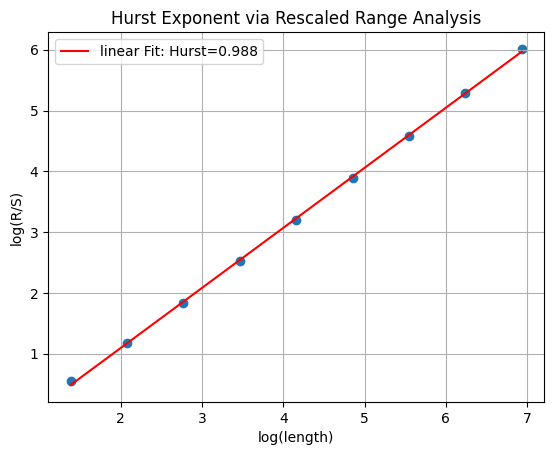

In [31]:

h_f.plot_fit()